# Project Data Science - Dog Adoption Research
## Goal
In this project i will conduct research regarding which factors influence the adoptability of a dog which is up for adoption. 

## Data
A dataset is taken from kaggle.com. [The dataset can be found here](https://www.kaggle.com/datasets/velazquezelsapetadoption)

The dataset includes all sorts of variables including the breed, color, age and size of a dog.
As well as different attributes of the dog, and with whom they have been socialized. 
The status and time between status changed is also noted.
I will use this to create an outcome variable: time spent in the rescue system.
For the dogs who have been adopted I will try and model which factors come into favour when being adopted. 
The data itsself is scraped of a site called petfinder.com which operates in the United States.

## importing required libraries

In [1]:
# Global imports

# Data transformation and computation modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Formatting libraries
import json
import datetime
import time
from pandas import json_normalize

# Statistics and models
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Model evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

- Numpy is used for creating array's, and computing mathematical operations on array's.
- Pandas is used to make a dataframe out of the data set, which is easy to work with. 
- JSON is used because some of the data is in a JSON format, and this needed interpretation.
- Matplotlib is an excellent tool for making graphical representations of data.
- Datetime was used to compute the time between going in the shelter and getting out.

## importing data set
### data set contains 722 Dogs, and 26 columns

In [2]:
# Import dataset
df = pd.read_csv("pet-adoption.csv")

# drop irrelevant variables
df.drop(['id', 'organization_id', 'url', 'species','organization_animal_id','tags', 'photos','primary_photo_cropped', 'videos', 'distance', 'contact', '_links', 'description', 'colors'], axis=1, inplace=True)
df.head(2)


,type,breeds,age,gender,size,coat,attributes,environment,name,status,status_changed_at,published_at
0,Dog,"{'primary': 'Terrier', 'secondary': 'Pug', 'mi...",Young,Male,Small,Short,"{'spayed_neutered': 'True', 'house_trained': '...","{'children': 'None', 'dogs': 'True', 'cats': '...",Ruff,adopted,2020-08-16 18:21:00+00:00,2020-07-21 20:52:42+00:00
1,Dog,"{'primary': 'German Shepherd Dog', 'secondary'...",Adult,Female,Medium,Medium,"{'spayed_neutered': 'True', 'house_trained': '...","{'children': 'None', 'dogs': 'None', 'cats': '...",Delilah,adopted,2020-07-31 01:39:20+00:00,2020-07-21 13:17:11+00:00


### The entire dataset was loaded in using pandas function read_csv() in the cell above
after the data is loaded in, i immediately delete columns which provide no use to me
to name a few;
- species,  They're all dogs.
- url,      Not interesting
- id,       Arbitrary number without meaning
- photos,   I've looked at the pictures and although they're all very cute, they provide no use to this research

The raw data is also printed above. The data is not in an optimal format yet as there is several columns which contain packed information. It is stored in JSON format and that is our first challenge of this research

As it became apparant to me later that even though the data looks like it is in JSON format, 
if you print out the type of it it shows up as a string.
So we will need to transform this from a string to regular JSON, 
and then split the columns so that 1 column = 1 piece of information.

## converting JSON to normal text

In [3]:
# convert JSON data

# replace " and unpack values
values = [json.loads(value.replace("'", "\"")) for value in df['attributes'].values]
values[2]
df1 = json_normalize(values)
df1.head()

# combine into original dataframe
col = df.columns.difference(['attributes'])
df = pd.concat([df[col], df1],axis=1)

### The problem with the imported format:


`df['attributes][2] = `

`"{'spayed_neutered': 'True', 'house_trained': 'False', 'declawed': 'None', 'special_needs': 'False', 'shots_current': 'True'}"`


### The data type is: String





because there is a " before and after every block of information. The interpreter therefor reads this as a string. 

With the above code, all " are deleted such that the information becomes of type dictionary:






`values[2] = `

`{'spayed_neutered': 'True',`
               ` 'house_trained': 'False',`
              `  'declawed': 'None',`
             `   'special_needs': 'False',`
               ` 'shots_current': 'True'}`

### Which is now in the correct format: Dictionary

Then we can apply json_normalize to "unfold" the information as seperate columns.

and lastly, the original dataframe and the new columns are added together such that they form 1 new dataframe. 

## Same JSON formatting is done for socialized in enviroment 

In [4]:
# convert JSON data 

# replace " and unpack values
values = [json.loads(value.replace("'", "\"")) for value in df['environment'].values]
df1 = json_normalize(values)
df1.head()

# combine into original dataframe
col = df.columns.difference(['environment'])
df = pd.concat([df[col], df1],axis=1)

## And for the breeds variable

In [5]:
# convert JSON data

# replace " and unpack values
values = [json.loads(value.replace("'", "\"")) for value in df['breeds'].values]
df1 = json_normalize(values)
df1.head()

# combine into original dataframe
col = df.columns.difference(['breeds'])
df = pd.concat([df[col], df1],axis=1)

## Reorder column's

In [6]:
#  Reorder columns
df = df.loc[:, ['published_at', 'status_changed_at', 'status','type', 'primary','name', 'gender','age', 'size', 'coat', 'house_trained', 'shots_current', 'spayed_neutered', 'special_needs', 'children', 'dogs', 'cats']]
df.head(2)

,published_at,status_changed_at,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats
0,2020-07-21 20:52:42+00:00,2020-08-16 18:21:00+00:00,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,True,True,True,False,None,True,None
1,2020-07-21 13:17:11+00:00,2020-07-31 01:39:20+00:00,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,False,True,True,False,None,None,None


## Create outcome variable time spent in rescue

Now that the data set is clean, we can start by making the outcome variable.
In order to do this we interpret the timestamps of columns published at, and status changed at.

This is done through the module of datetime, and time.
By using the function time difference, we can easily get a list of data type datetime containing the information we need
Because it is returned to us in datetime, we can easily have it interpretted by computational functions.

The following code does roughly this:
1. create empty list
2. iterate over all dogs 
3. determine when dog was brought in
4. determine when dog was adopted
5. calculate days between this
6. fill list with values
7. create new column

In [7]:
# make outcome variable

# make empty list which will hold values for new column
days_in_rescue = []

# loop over published at and status changed
for i, value in enumerate(df['published_at']):

    # set time in
    time_in = df.iloc[i]['published_at']
    time_in = datetime.datetime.strptime(time_in[0:10], "%Y-%m-%d")


    # set time out
    time_out = df.iloc[i]['status_changed_at']
    time_out = datetime.datetime.strptime(time_out[0:10], "%Y-%m-%d")

    # calculate difference
    time_difference = time_out - time_in

    # append list with the difference 
    days_in_rescue.append(time_difference.days)

# create new column
df['time_in_rescue'] = days_in_rescue

# drop 2 constructor columns
df.drop(['published_at', 'status_changed_at'], axis=1, inplace=True)

# make a copy for later
copy = df.copy()

df.head(2)

,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
0,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,True,True,True,False,None,True,None,26
1,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,False,True,True,False,None,None,None,10


## Drop adoptable dogs from the data

now that the outcome variable has been made, the data transformation is almost complete.

first we drop the adoptable dogs from the dataframe because they're not the population of interest for this research. 

The population of interest decays to 506

In [8]:
# drop adoptable dogs
df.drop(df[df.status == 'adoptable'].index, inplace=True)
df

,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
0,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,True,True,True,False,None,True,None,26
1,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,False,True,True,False,None,None,None,10
3,adopted,Dog,Labrador Retriever,Louie,Male,Young,Medium,None,True,True,True,False,True,True,True,5
4,adopted,Dog,Border Collie,Kenny,Male,Adult,Medium,Long,True,True,True,False,None,None,None,2
5,adopted,Dog,Labrador Retriever,Stormy,Male,Senior,Large,Medium,True,True,True,False,True,True,True,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,adopted,Dog,Shepherd,Perch,Male,Baby,Medium,Short,False,True,True,False,True,True,None,0
717,adopted,Dog,Boxer,Dina,Female,Young,Medium,Short,False,True,True,False,None,None,None,9
719,adopted,Dog,Terrier,Omar,Male,Baby,Medium,Medium,True,True,True,False,None,True,None,26
720,adopted,Dog,Shepherd,Dora,Female,Baby,Large,None,False,True,False,False,True,True,None,0


## Map string to boolean values

In [9]:
# Make copy 
data1_bool = df.copy()

# change str to bool
data1_bool['house_trained'] = data1_bool['house_trained'].map({'True': True, 'False': False})
data1_bool['shots_current'] = data1_bool['shots_current'].map({'True': True, 'False': False})
data1_bool['spayed_neutered'] = data1_bool['spayed_neutered'].map({'True': True, 'False': False})
data1_bool['children'] = data1_bool['children'].map({'True': True, 'None': False, 'False' : False})
data1_bool['dogs'] = data1_bool['dogs'].map({'True': True, 'None': False, 'False' : False})
data1_bool['cats'] = data1_bool['cats'].map({'True': True, 'None': False, 'False' : False})
data1_bool['special_needs'] = data1_bool['special_needs'].map({'True': True, 'None': False, 'False' : False})

## Change boolean values to dummy variables 

In [10]:
# change bool to dummy int
data1_bool["house_trained"] = data1_bool["house_trained"].astype(int)
data1_bool["shots_current"] = data1_bool["shots_current"].astype(int)
data1_bool["spayed_neutered"] = data1_bool["spayed_neutered"].astype(int)
data1_bool["special_needs"] = data1_bool["special_needs"].astype(int)
data1_bool["children"] = data1_bool["children"].astype(int)
data1_bool["dogs"] = data1_bool["dogs"].astype(int)
data1_bool["cats"] = data1_bool["cats"].astype(int)

## Update original data frame with new dumy variables

In [11]:
# update df
df = data1_bool
df.head(2)

,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
0,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,1,1,1,0,0,1,0,26
1,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,0,1,1,0,0,0,0,10


## Check if there is any missing data

In [12]:
df.isnull().sum()

status             0
type               0
primary            0
name               0
gender             0
age                0
size               0
coat               0
house_trained      0
shots_current      0
spayed_neutered    0
special_needs      0
children           0
dogs               0
cats               0
time_in_rescue     0
dtype: int64

## Set independant variables to X and dependant variable to Y

In [13]:
# set x and y
y = df['time_in_rescue']
x = df[['house_trained', 'shots_current', 'spayed_neutered', 'special_needs', 'children', 'dogs', 'cats']]

## Print correlation matrix

A correlation matrix is a table that shows the statistical relationship between a set of variables. It gives the correlation coefficient between each pair of variables, which is a measure of the strength and direction of the relationship. The correlation coefficient can range from -1 to 1, where a value of -1 indicates a strong negative relationship, a value of 0 indicates no relationship, and a value of 1 indicates a strong positive relationship.

In this table we can see that the highest correlation between time in rescue and an independant variable is 0.12 for shots current, and 0.11 for special needs. 

So at face value special needs has the biggest influence on the outcome 

In [14]:
df.corr()

/var/folders/bx/c7_76bgj2zs1_dhl31l18hxc0000gp/T/ipykernel_4279/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
house_trained,1.000000,0.163006,0.243611,0.121479,0.281518,0.263965,0.077728,0.099749
shots_current,0.163006,1.000000,0.495382,0.062168,0.182305,0.215743,0.089081,0.127210
spayed_neutered,0.243611,0.495382,1.000000,0.043912,0.104754,0.121716,0.080515,0.048914
special_needs,0.121479,0.062168,0.043912,1.000000,-0.018148,0.023483,0.005538,0.116175
children,0.281518,0.182305,0.104754,-0.018148,1.000000,0.588072,0.439604,-0.107371
dogs,0.263965,0.215743,0.121716,0.023483,0.588072,1.000000,0.399301,0.018029
cats,0.077728,0.089081,0.080515,0.005538,0.439604,0.399301,1.000000,-0.020369
time_in_rescue,0.099749,0.127210,0.048914,0.116175,-0.107371,0.018029,-0.020369,1.000000


## Print a summary of descriptive statistics about the sample

Descriptive statistics are techniques used to summarize, organize, and describe a dataset. 

They are used to describe the basic features of the data and to provide a snapshot of the data's distribution, including measures of central tendency.

In this case i think it is notable that the mean of a binary variable directly translates to what percentage of the population has that attribute.

so for house trained the mean is 0,.347 which means that 34.7% of sample population is trained to be inside a house. 


In [15]:
df.describe()

,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.347826,0.824111,0.747036,0.017787,0.511858,0.697628,0.314229,7.019763
std,0.476752,0.381103,0.435141,0.132306,0.500354,0.459740,0.464668,6.933889
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,5.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.000000


## Visualize the most common breeds of adopted dogs

<AxesSubplot: title={'center': 'Amount of dogs per breed that are adopted'}>

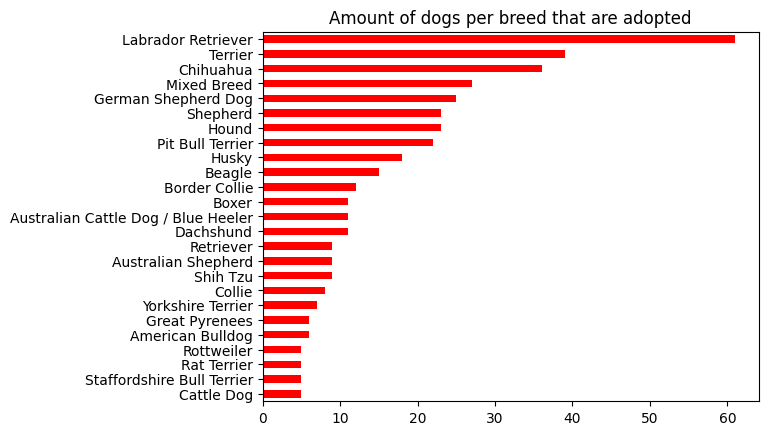

In [16]:
df['primary'].value_counts()[:25].sort_values().plot(kind='barh', title='Amount of dogs per breed that are adopted', color='red')

## Show amount of dogs adopted per age catergory

<AxesSubplot: title={'center': 'Age stratification of adopted dogs'}>

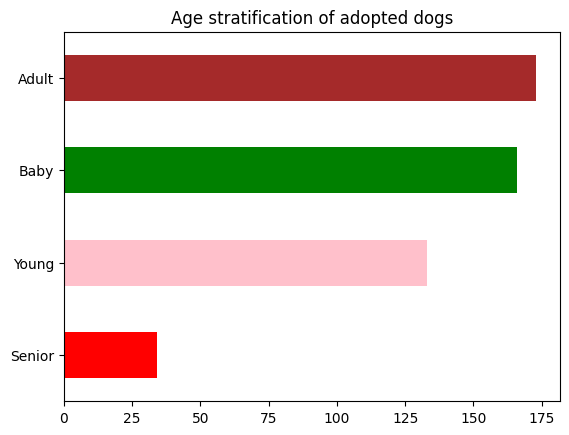

In [17]:
# give bar chart pretty colors
bar_colors = ['red', 'pink', 'green', 'brown']
df['age'].value_counts().sort_values().plot(kind='barh', title='Age stratification of adopted dogs', color=bar_colors)

## Show distribution of the outcome variable

Text(0.5, 1.0, 'Outcome variable histogram')

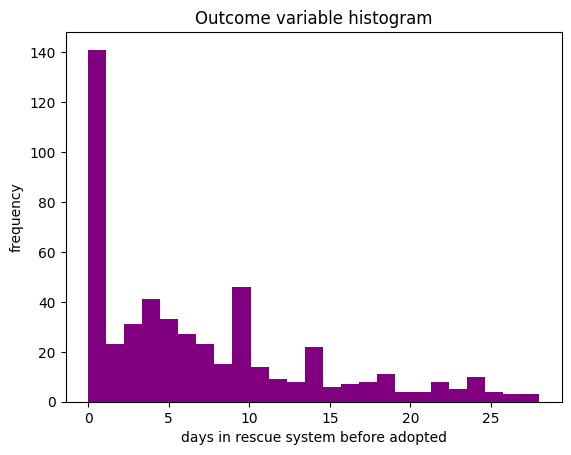

In [18]:
# plot outcome variable in historgram
plt.hist(df['time_in_rescue'], color='purple', bins=25)

# set labels and title
plt.xlabel('days in rescue system before adopted')
plt.ylabel('frequency')
plt.title('Outcome variable histogram')

## Show how much percentage from the sample has a certain attribute

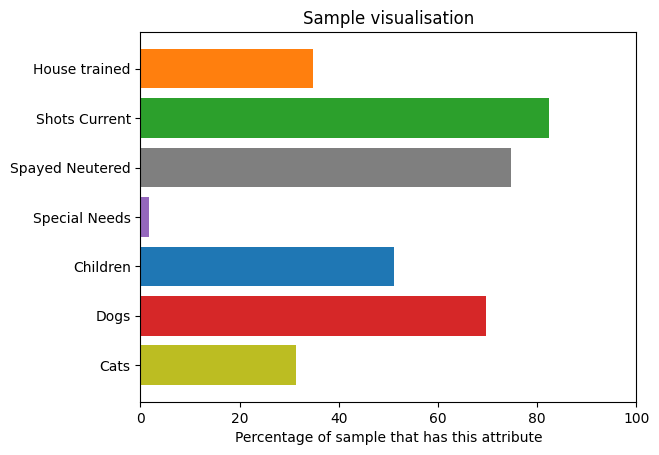

In [19]:
# Got most of this code from matplotlib docs https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html

# set y titles
Attributes = ('House trained', 'Shots Current', 'Spayed Neutered', 'Special Needs', 'Children', 'Dogs', 'Cats')
y_pos = np.arange(len(Attributes))

# calculate percentage of sample
averages = df[['house_trained', 'shots_current', 'spayed_neutered', 'special_needs', 'children', 'dogs', 'cats']].mean() * 100

# set bar colors
bar_colors = ['tab:orange', 'tab:green', 'tab:gray', 'tab:purple', 'tab:blue', 'tab:red', 'tab:olive']

# create sub plot
fig, ax = plt.subplots()

# set colors
ax.barh(y_pos, averages, align='center', color=bar_colors)
ax.set_yticks(y_pos, labels=Attributes)

# make a vertical bar chart
ax.invert_yaxis()  

# set labels
ax.set_xlabel('Percentage of sample that has this attribute')
ax.set_title('Sample visualisation')

# show until 100%
plt.xlim([0, 100])
plt.show()

## Split train and test data, 70% of data is used to train the model, and 30% is left to make predictions. 

Now we will splitting the dataset into a training set and a test set. The purpose of this is to evaluate the performance of a model on new, unseen data.

The training set is used to train the model, which involves adjusting the model's parameters.
The test set is then used to evaluate the model's performance on data it has not seen before. 

By evaluating the model's performance on the test set, we can get a better understanding of how well the model will perform on real-world data. 
This is important because we want to ensure that the model is not overfitting to the training data, which would result in poor generalization to new data.

In [20]:
# split in training and test data.
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.3, random_state=777)

## Make multiple linear regression model and predict results

In [21]:
# determine model 
model=LinearRegression()

# train model
model.fit(x_train, y_train)

# predict outcomes
y_pred = model.predict(x_test)

## Evaluate the linear regression model

In [22]:
# calculate r2 score
print(f'R squared = {r2_score(y_test, y_pred)}')
print(f'MSE = {mean_squared_error(y_test, y_pred)}')

R squared = 0.02278825828990516
MSE = 40.750161050699695


So the R2 of my linear regression model is 0.022788....

This means that of the actual outcomes, 2,278% can be explained by this model. 

This is on the low side, as a weak R2 is 20% and this is thus 10 times as small. 

This means that our model may be significant, but it is not very accurate.

In order to check out other parameters of our model statistics we will compute another with statsmodel, as this shows more data


## compute another multiple linear regression model but with a fancy summary

In [23]:
# add constant for different calculation of the same model
x = sm.add_constant(x)

# make linear regression with statsmodel
model = sm.OLS(y, x).fit()

# print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         time_in_rescue   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.718
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           3.83e-05
Time:                        17:38:28   Log-Likelihood:                -1681.1
No. Observations:                 506   AIC:                             3378.
Df Residuals:                     498   BIC:                             3412.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.3066      0.816     

Of the linear regression model which was calculated with statsmodel on the same data, but without the training, test split. The R2 is 6,2%

This may be by chance and it doesn't mean that this model is better than the previous one. There has been an additional step which is adding a constant to the independant variables.

This may have resulted in a slightly higher R2. 

Of the independant variables 4 are significant, they are significant if the p value is less than 0.05.

The significant variables are:
1. is house trained
2. has shots current
3. has special needs
4. socialized with children

These 4 variables have a 95% of having an influence on the outcome variable time in rescue. 

## visualise accuracy of the model

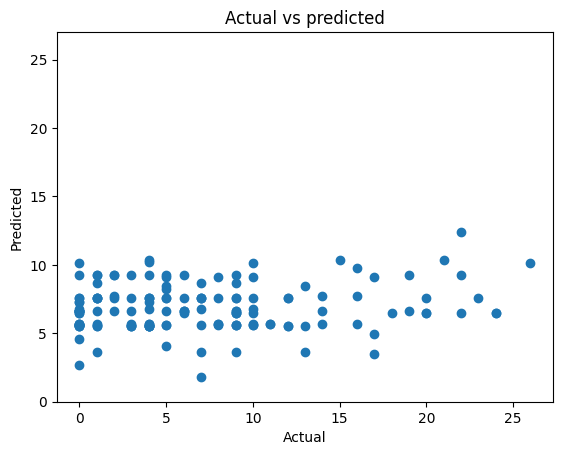

In [24]:
# plot the predicted values vs. the actual values
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.ylim([0, 27])
plt.title('Actual vs predicted')
plt.show()

even though there appears to be a pattern in this data, sort of a horizontal line, this does not imply that it is a good fit.

For the data to be a good fit you want to have a scatter in the form of a diagonal line from (0, 0) to (25, 25) on the plot.

This would imply that if the predicted value was 5, the actual value was also 5. 

What we're seeing here looks like my model under shoots a lot of predicted values.

actual values go up to 26, and the highest predicted value appears to be 13. 



## Make a polynomial model 

Because we're not happy yet with a R2 score of 2,28 and 6,2, we will try and make a polynomial model instead of linear. 

In [25]:
# got this code from https://enjoymachinelearning.com/blog/multivariate-polynomial-regression-python/

# set variables
x_values = x[['shots_current', 'house_trained', 'special_needs', 'children','spayed_neutered','dogs','cats']]
y_values = y

# set degrees of freedom
degree = 3

# set model
poly_model = PolynomialFeatures(degree)

# transform data to have poly features
poly_x = poly_model.fit_transform(x_values)

# fitting the model
poly_model.fit(poly_x, y_values)

# add linear regression to the base of the model
regression_model = LinearRegression()
regression_model.fit(poly_x, y_values)

# making predictions with model.
y_pred = regression_model.predict(poly_x)

# calculate coefficiencies
regression_model.coef_

# evaluate model
print(f'R squared = {r2_score(y_values, y_pred)}')
print(f'MSE = {mean_squared_error(y_values, y_pred)}')

R squared = 0.16922364169773207
MSE = 39.86380591803955


R squared of the polynomial model is 16,92% which is significantly higher than our linear model. 

The polynomial model has a better fit than the linear model, and thus we can conclude the relationship to not be linear 

## Visualize the accuracy of the polynomial model

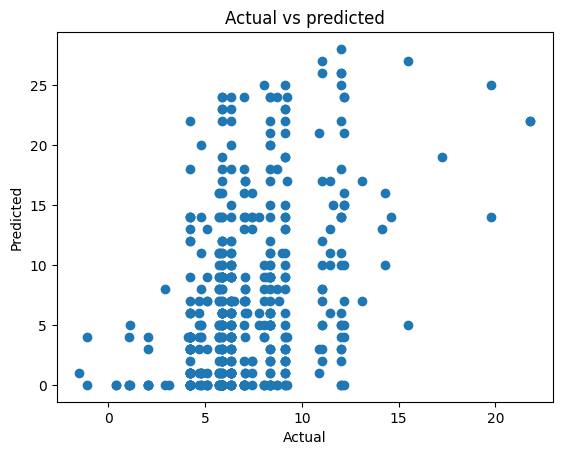

In [26]:
# plot predicted values vs. actual
plt.scatter(y_pred, y_values)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs predicted')
plt.show()

So this model has a better fit to the data than the linear model. 

This is also visible in the plot of actual vs predicted. 

You can clearly see that the model isn't only undershooting anymore, but the data points are somewhat in a diagonal scatter across the plot.

this is a positive change since last model. And if we could make this model more accurate, the points will converge towards the diagonal line.

## calculate the optimal degrees of freedom for the polynomial model

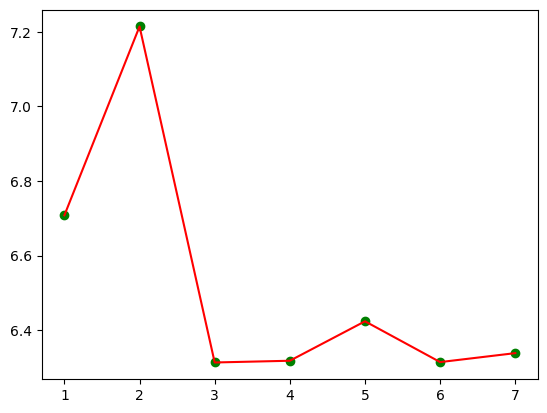

In [27]:
# got this code from https://enjoymachinelearning.com/blog/multivariate-polynomial-regression-python/

number_degrees = [1,2,3,4,5,6,7]
plt_mean_squared_error = []
for degree in number_degrees:

   poly_model = PolynomialFeatures(degree=degree)
  
   poly_x_values = poly_model.fit_transform(x_values)
   poly_model.fit(poly_x_values, y_values)
  
   regression_model = LinearRegression()
   regression_model.fit(poly_x_values, y_values)
   y_pred = regression_model.predict(poly_x_values)
  
   plt_mean_squared_error.append(mean_squared_error(y_values, y_pred, squared=False))

plt.scatter(number_degrees,plt_mean_squared_error, color="green")
plt.plot(number_degrees,plt_mean_squared_error, color="red") 
plt.show()

This is code i found online which proves what the best degrees of freedom of your model is to get the lowest MSE possible, in this case: 3.